In [1]:
import numpy as np
import geopandas as gpd
import json
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
from tree_detection_framework.evaluation.evaluate import match_points, assess_matches

pd.options.mode.chained_assignment = None  # default='warn'

PLOT_BOUNDS = "/ofo-share/species-prediction-project/raw/ground-reference/ofo_ground-reference_plots.gpkg"
SHIFTS_FILE = "/ofo-share/species-prediction-project/intermediate/shifted_field_trees/shifts_per_dataset.json"
SHIFT_QUALITY_FILE = (
    "/ofo-share/scratch-david/species-tree-detection-eval/good_shifts.csv"
)
SHIFTED_TREE_FILES = Path(
    "/ofo-share/species-prediction-project/intermediate/shifted_field_trees"
)
PREDS_FOLDER = "/ofo-share/scratch-david/species-tree-detection-eval/predictions"


def eval_dataset(preds_folder,dataset):
    tree_pred = f"{preds_folder}/{dataset}.gpkg"
    tree_gt = f"/ofo-share/species-prediction-project/intermediate/shifted_field_trees/{dataset}.gpkg"

    tree_preds = gpd.read_file(tree_pred)
    plot_bounds = gpd.read_file(PLOT_BOUNDS)
    try:
        tree_gt = gpd.read_file(tree_gt)
    except:
        print(f"Skipping {tree_gt} because it doesn't exist")
        return

    shifts = json.load(open(SHIFTS_FILE, "r"))
    # Get the particular shift for this dataset
    shift = shifts[dataset]
    # Get the bounds for this dataset
    plot = dataset[:4]
    plot_bound = plot_bounds.query("plot_id==@plot")

    tree_gt.to_crs(tree_preds.crs, inplace=True)
    plot_bound.to_crs(tree_preds.crs, inplace=True)
    # The trees used in evaluation are shifted. So we need to shift the plot bounds the corresponding amount
    plot_bound.geometry = plot_bound.translate(xoff=shift[0], yoff=shift[1])

    tree_preds = tree_preds.clip(plot_bound)

    matches = match_points(
        treetop_set_1=tree_gt,
        treetop_set_2=tree_preds,
        height_column_1="height",
        height_column_2="height",
        vis=False,
    )

    precision, recall, f1 = assess_matches(
        matches=matches, n_ground_truth=len(tree_gt), n_predictions=len(tree_preds)
    )

    return precision, recall, f1

def eval_all_preds(preds_folder):
    quality_shifts = pd.read_csv(SHIFT_QUALITY_FILE)
    quality_shifts = quality_shifts[quality_shifts["Unnamed: 1"] == "Good"]

    results = [eval_dataset(preds_folder, d[:-5]) for d in quality_shifts.dataset.tolist()]
    return results

def plot_results(results):
    results = list(filter(lambda x: x is not None, results))

    precision, recall, f1 = list(zip(*results))

    mean_precision = np.mean(precision)
    mean_recall = np.mean(recall)
    mean_f1 = np.mean(f1)

    print(f"Mean precision: {mean_precision}, mean recall: {mean_recall}, mean f1: {mean_f1}")

    plt.hist(f1)
    plt.title("F1")
    plt.show()

    plt.hist(precision)
    plt.title("precision")
    plt.show()

    plt.hist(recall)
    plt.title("recall")
    plt.show()

    plt.scatter(precision, recall)
    plt.xlabel("Precision")
    plt.ylabel("Recall")
    plt.show()

    return mean_precision, mean_recall, mean_f1



Skipping /ofo-share/species-prediction-project/intermediate/shifted_field_trees/0031_001420_001418.gpkg because it doesn't exist
Skipping /ofo-share/species-prediction-project/intermediate/shifted_field_trees/0042_001419_001418.gpkg because it doesn't exist
Skipping /ofo-share/species-prediction-project/intermediate/shifted_field_trees/0065_000333_000335.gpkg because it doesn't exist
Skipping /ofo-share/species-prediction-project/intermediate/shifted_field_trees/0069_000781_000780.gpkg because it doesn't exist
Skipping /ofo-share/species-prediction-project/intermediate/shifted_field_trees/0115_000643_000644.gpkg because it doesn't exist
Skipping /ofo-share/species-prediction-project/intermediate/shifted_field_trees/0115_000645_000743.gpkg because it doesn't exist
Skipping /ofo-share/species-prediction-project/intermediate/shifted_field_trees/0116_000646_000647.gpkg because it doesn't exist
Skipping /ofo-share/species-prediction-project/intermediate/shifted_field_trees/0031_001420_00141

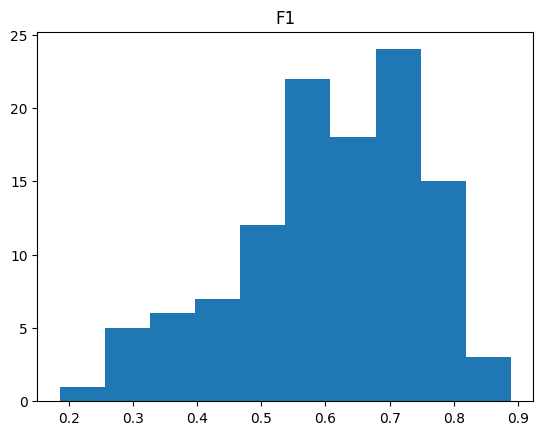

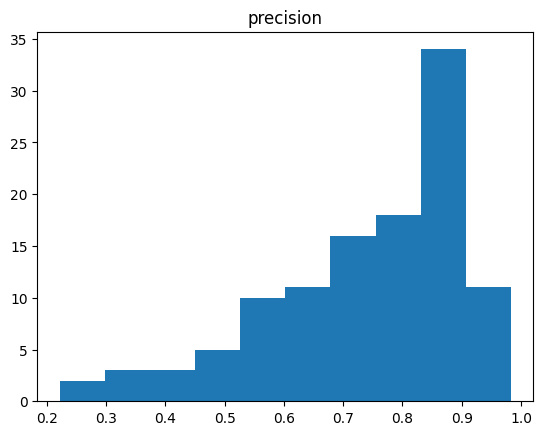

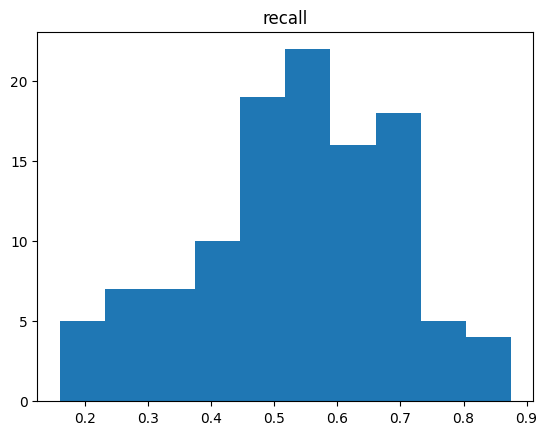

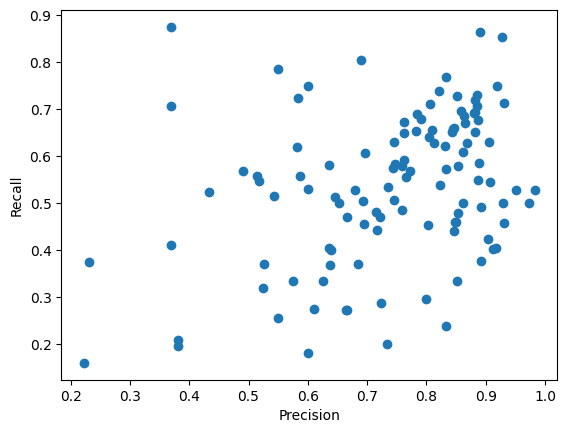

Mean precision: 0.6138151034305965, mean recall: 0.6531745539967814, mean f1: 0.6158141230391313


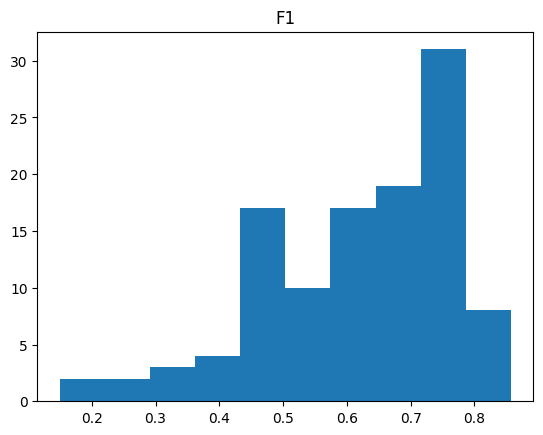

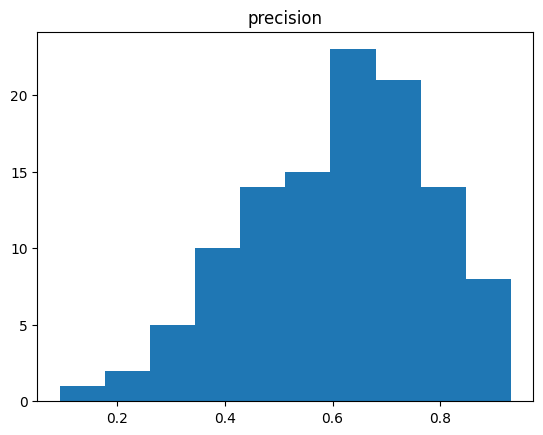

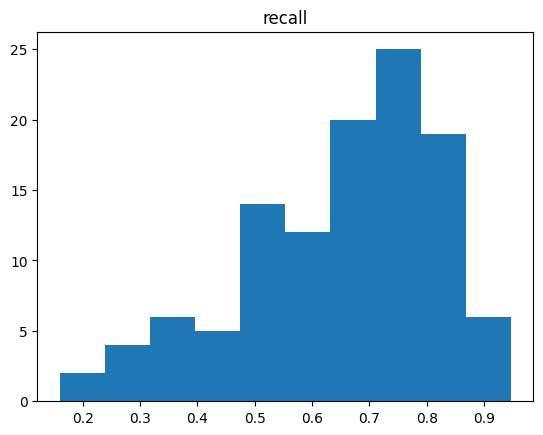

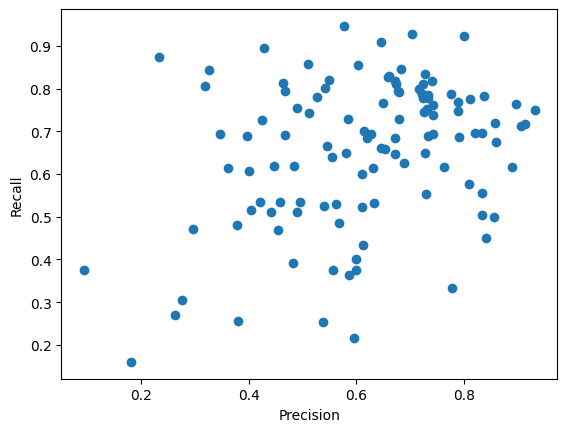

Mean precision: 0.7532031399513368, mean recall: 0.5584485381822734, mean f1: 0.6287691995830718


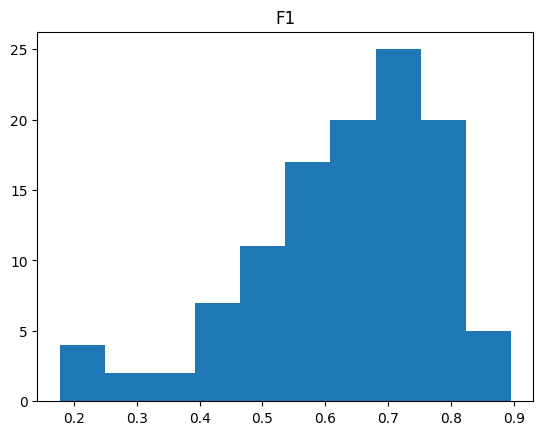

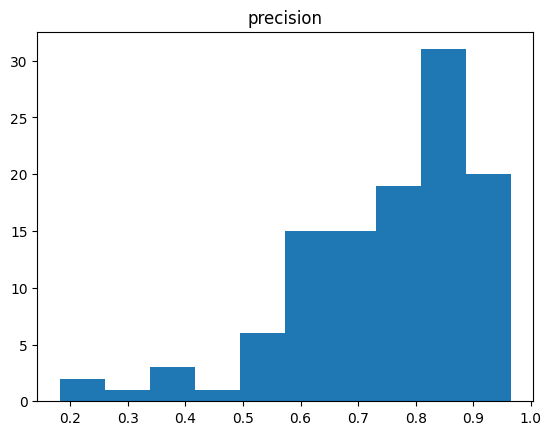

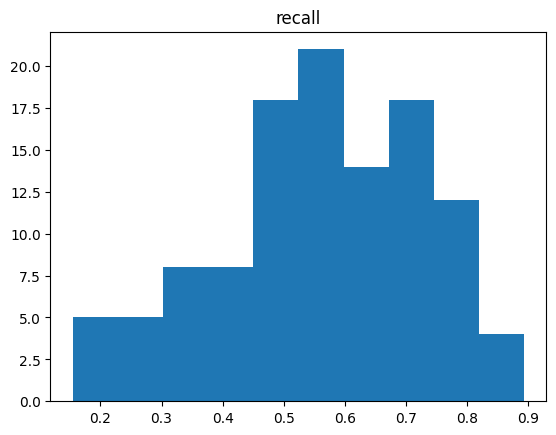

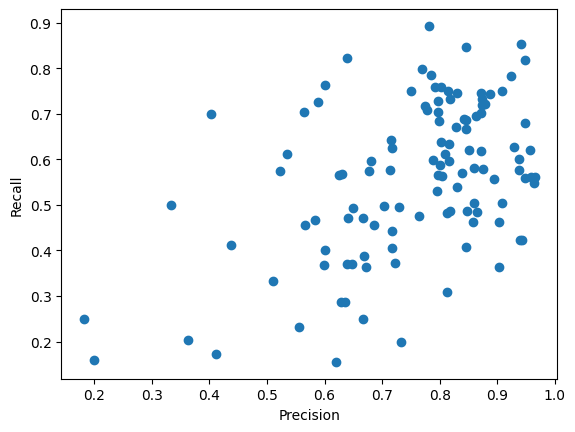

Mean precision: 0.7411539482179763, mean recall: 0.5126740458883621, mean f1: 0.5907543544696588


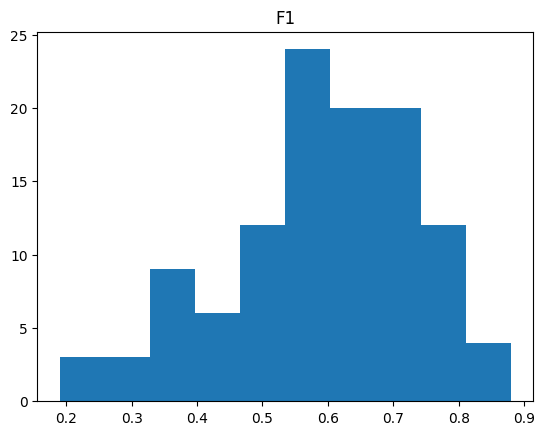

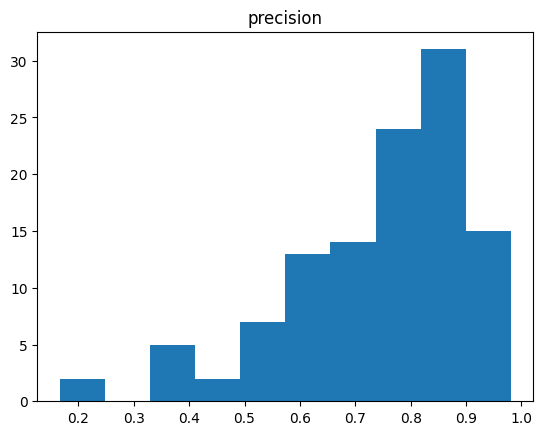

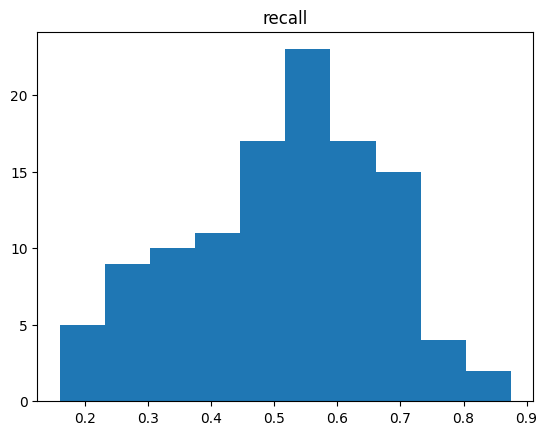

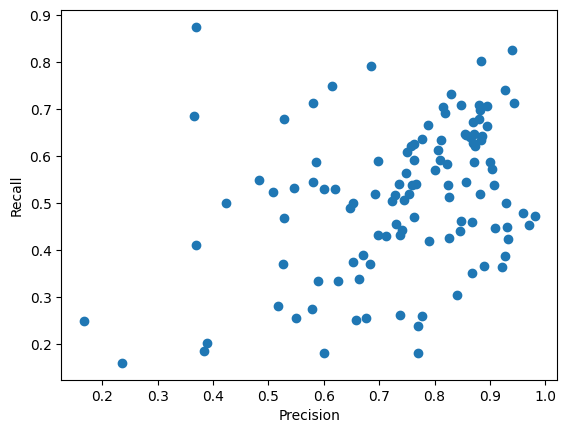

Mean precision: 0.811678841494307, mean recall: 0.439045829648341, mean f1: 0.5553944048574694


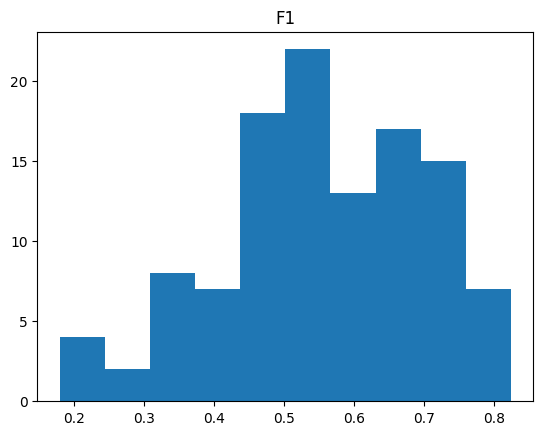

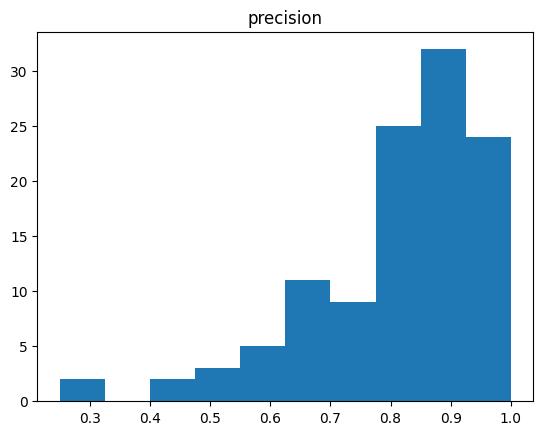

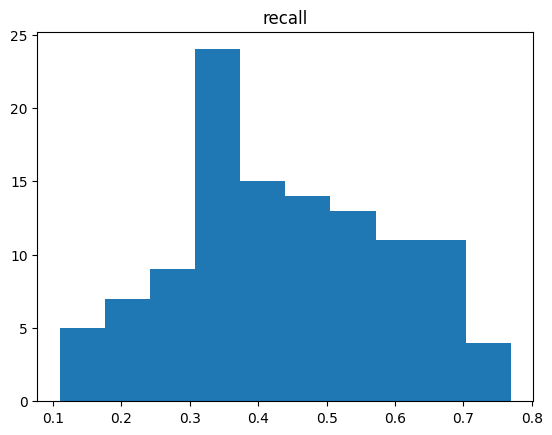

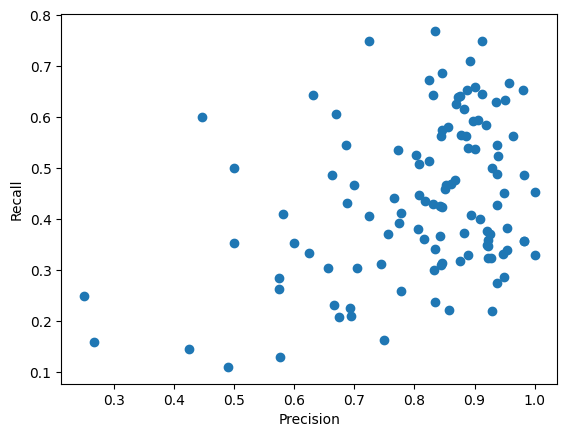

Mean precision: 0.7733102678688029, mean recall: 0.5297881119320578, mean f1: 0.6161366505197297


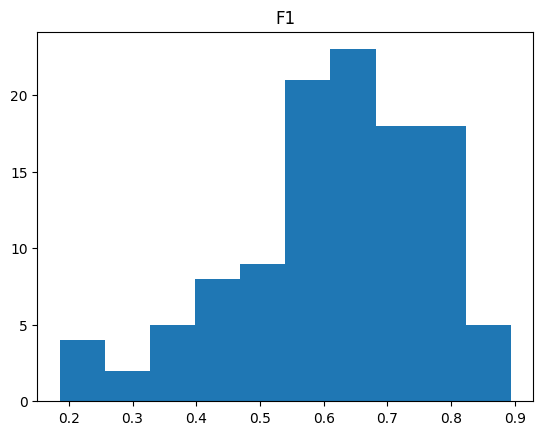

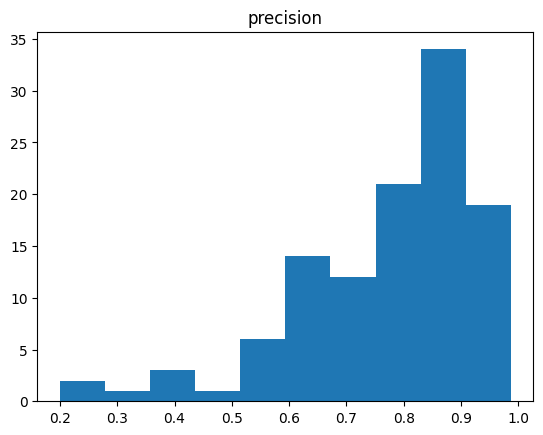

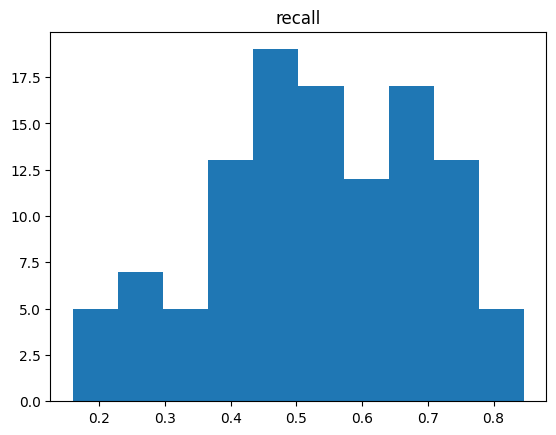

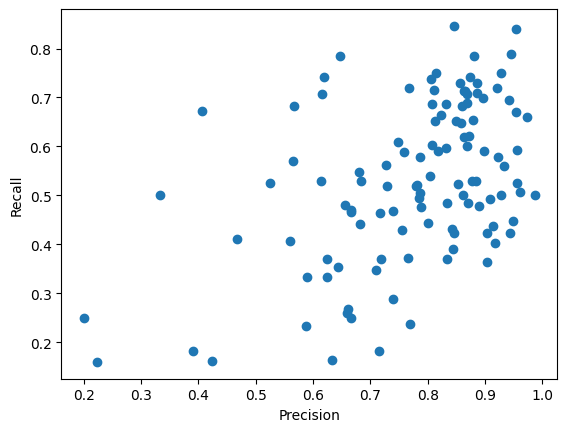

Mean precision: 0.7347348925900293, mean recall: 0.5823468273017445, mean f1: 0.6366888238304864


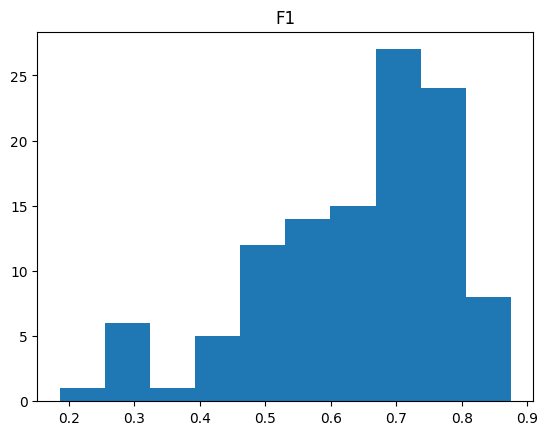

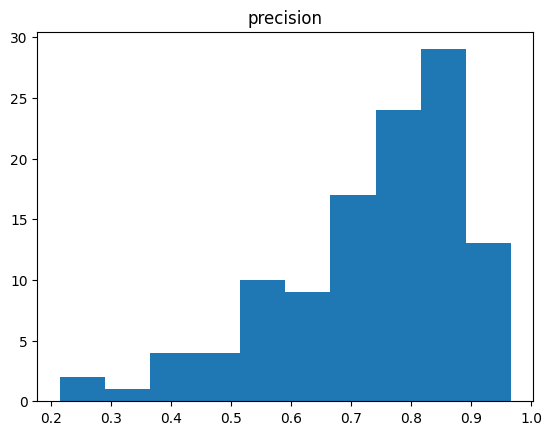

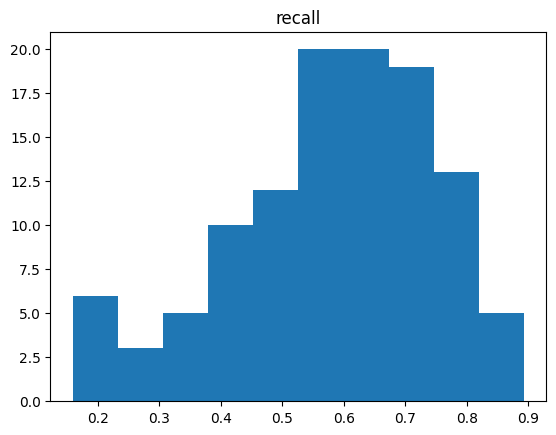

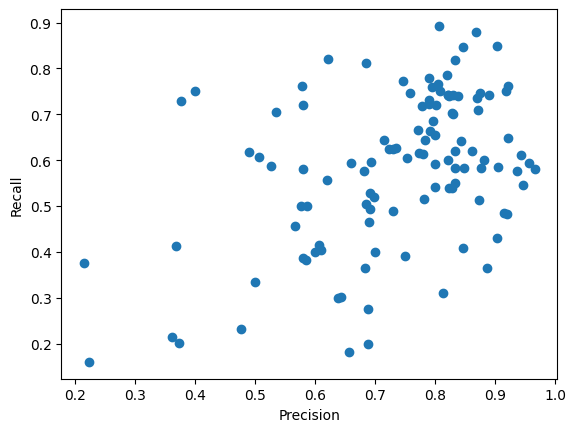

Mean precision: 0.7547692728799203, mean recall: 0.5519348840185627, mean f1: 0.6248848401413635


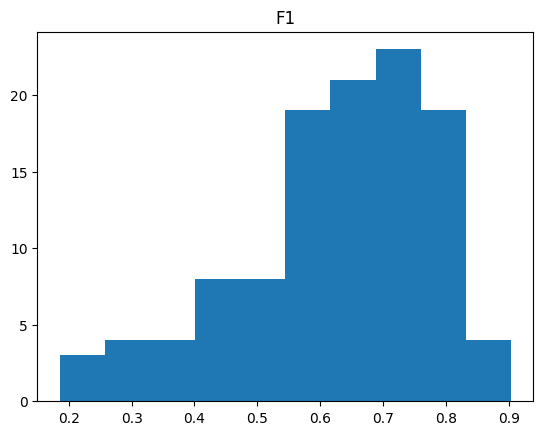

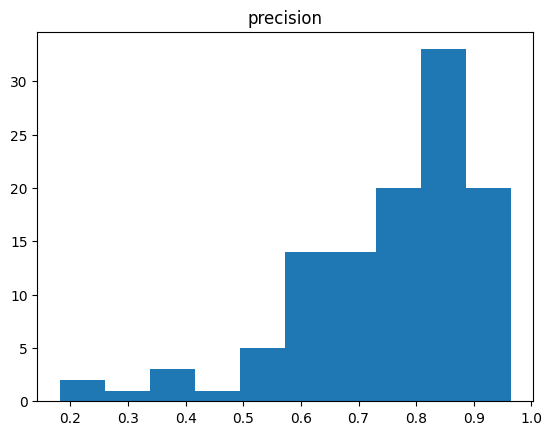

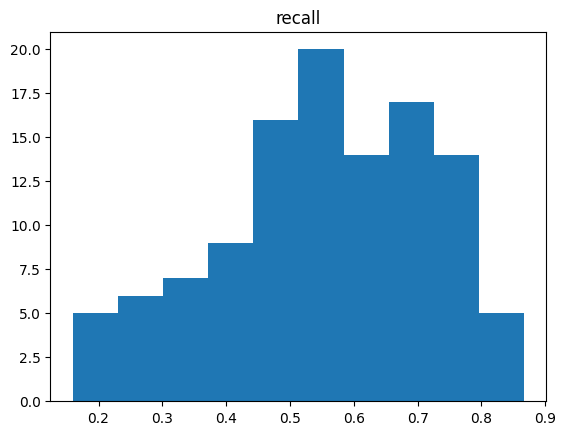

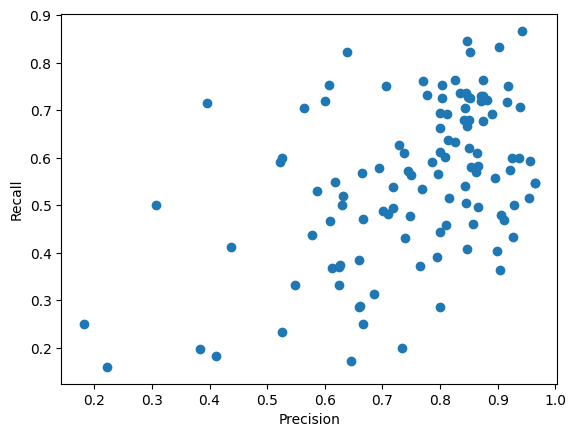

Mean precision: 0.7032883438695393, mean recall: 0.6074180310352641, mean f1: 0.6380268842171495


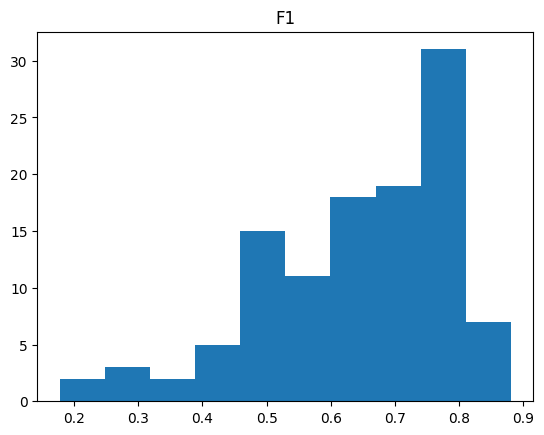

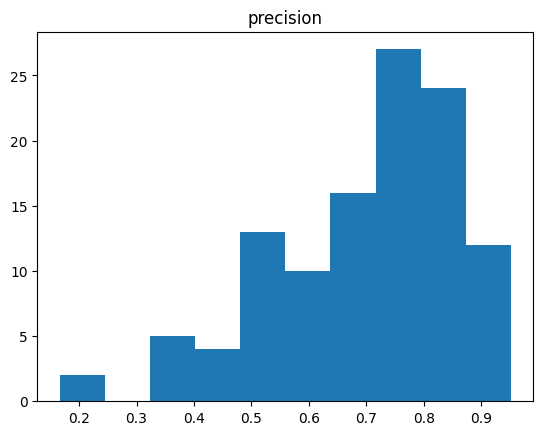

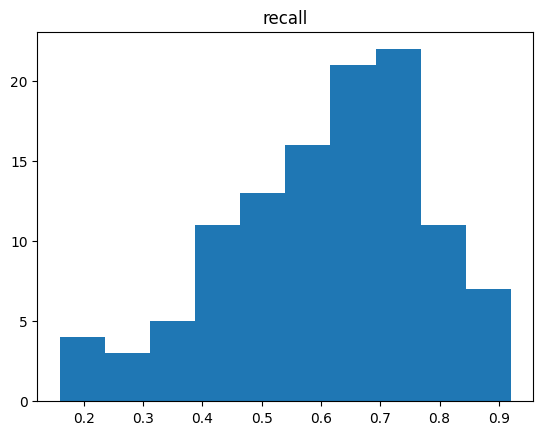

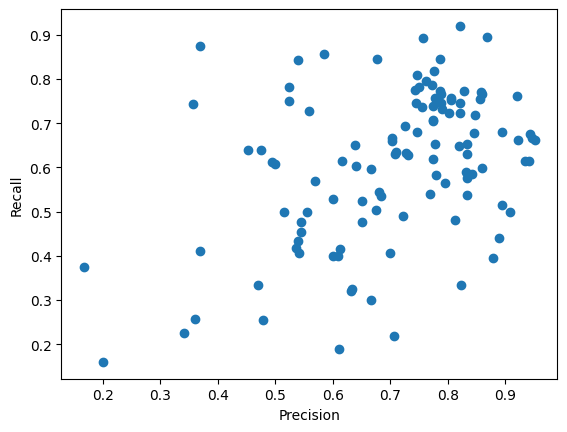

In [2]:
all_parameterization_folders = list(Path(PREDS_FOLDER).glob("*"))

all_parameterization_results = [eval_all_preds(f) for f in all_parameterization_folders]

results = [plot_results(r) for r in all_parameterization_results]

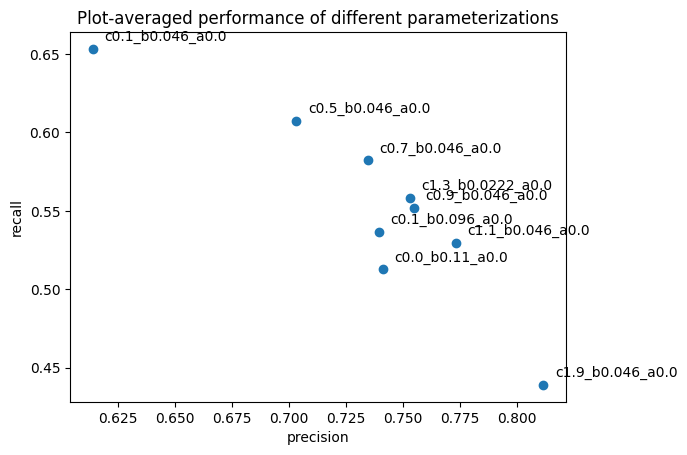

In [3]:
precision, recall, f1 = zip(*results)

tags = [f.name[12:] for f in all_parameterization_folders]
plt.scatter(precision, recall)

for i, tag in enumerate(tags):
    plt.annotate(tag, (precision[i]+0.005, recall[i]+0.005))
plt.title("Plot-averaged performance of different parameterizations")
plt.xlabel("precision")
plt.ylabel("recall")
plt.show()


In [4]:
print(list(zip(tags, f1)))

[('c0.1_b0.096_a0.0', np.float64(0.6067689362450984)), ('c0.1_b0.046_a0.0', np.float64(0.6158141230391313)), ('c1.3_b0.0222_a0.0', np.float64(0.6287691995830718)), ('c0.0_b0.11_a0.0', np.float64(0.5907543544696588)), ('c1.9_b0.046_a0.0', np.float64(0.5553944048574694)), ('c1.1_b0.046_a0.0', np.float64(0.6161366505197297)), ('c0.7_b0.046_a0.0', np.float64(0.6366888238304864)), ('c0.9_b0.046_a0.0', np.float64(0.6248848401413635)), ('c0.5_b0.046_a0.0', np.float64(0.6380268842171495))]


In [5]:
pl

NameError: name 'pl' is not defined